# Constructing a Probabilistic Inference Engine for a Crop Recommendation System
This notebook implements a probabilistic inference engine for crop recommendation using soil and environmental data. The project connects:

Probability modeling
Information theory (NLL, Cross-Entropy, KL Divergence)
Decision theory (Expected Utility)
Dataset: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset


In [ ]:
import pandas as pd # Import pandas for data manipulation and analysis
from sklearn.model_selection import train_test_split # Import for splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler # Import for standardizing features
from sklearn.naive_bayes import GaussianNB # Import Gaussian Naive Bayes classifier
from sklearn.ensemble import RandomForestClassifier # Import Random Forest classifier
from sklearn.linear_model import LogisticRegression # Import Logistic Regression classifier
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for enhanced data visualization
import numpy as np # Import numpy for numerical operations
from sklearn.metrics import log_loss # Import log_loss for computing Negative Log-Likelihood
from sklearn.metrics import brier_score_loss # Import brier_score_loss for computing Brier Score
from sklearn.calibration import calibration_curve # Import calibration_curve for plotting reliability diagrams
import matplotlib.pyplot as plt # Re-import matplotlib (already imported, but fine)
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler for scaling features to a given range
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

##Exploratory Data Analytics
In this section, we load the dataset and perform an initial analysis to understand the distribution of features and the balance of our target classes.

In [ ]:
df = pd.read_csv("Crop_recommendation2.csv") # Load the dataset from the specified CSV file into a pandas DataFrame
df.head() # Display the first 5 rows of the DataFrame to get an initial look at the data

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
print(df.columns) # Print the names of all columns in the DataFrame

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')


##Crop Distribution (Empirical P(x))
We visualize the frequency of each crop type. This represents the Empirical Prior Probability $P(x)$ of the crops in our system before considering specific soil conditions.

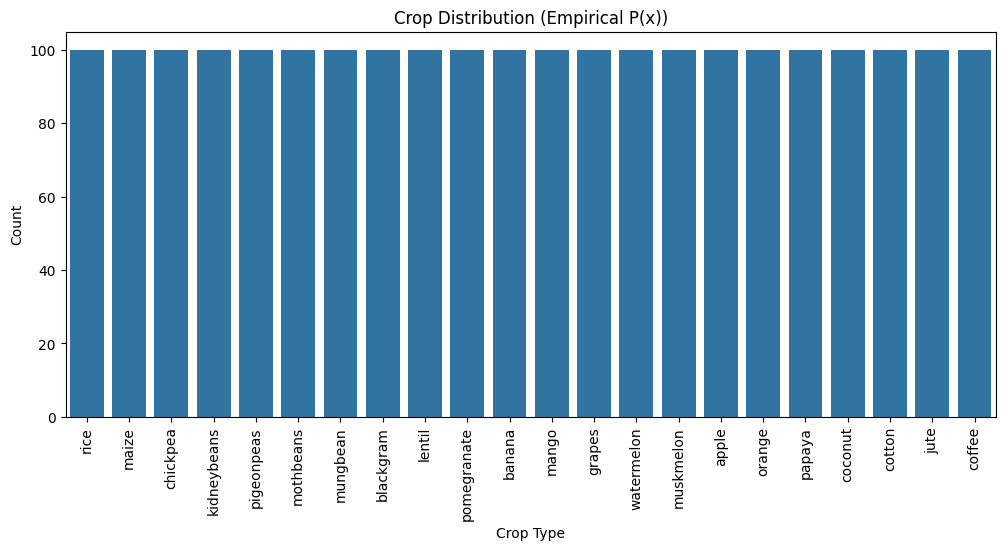

In [ ]:
plt.figure(figsize=(12,5)) # Create a new figure with a specified size
sns.countplot(x="label", data=df) # Create a bar plot showing the counts of each unique value in the 'label' column

plt.xticks(rotation=90) # Rotate x-axis labels by 90 degrees for better readability
plt.title("Crop Distribution (Empirical P(x))") # Set the title of the plot
plt.xlabel("Crop Type") # Set the label for the x-axis
plt.ylabel("Count") # Set the label for the y-axis

plt.show() # Display the plot

In [ ]:
print("Number of classes:", df["label"].nunique()) # Print the number of unique crop types (classes)
print(df["label"].value_counts()) # Print the count of each unique crop type

Number of classes: 22
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64


##2. System Definition & Variable Selection
To build our inference engine, we define the variables that represent the agricultural system:System: Recommendation based on environmental/soil inputs.Target Variable ($x$): The Crop Type (e.g., rice, maize).Observation Variables ($y$): Features like Nitrogen (N), Phosphorous (P), Potassium (K), temperature, and humidity.

In [ ]:
X = df.drop("label", axis=1) # Create a DataFrame X by dropping the 'label' column (features)
y = df["label"] # Create a Series y containing only the 'label' column (target variable)

In [ ]:
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder for converting categorical labels to numerical
from sklearn.model_selection import train_test_split # Import train_test_split for splitting data

encoder = LabelEncoder() # Initialize LabelEncoder
y_encoded = encoder.fit_transform(y) # Encode the target variable 'y' into numerical labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,   # Use the features X and the encoded target y_encoded
    test_size=0.2, # Allocate 20% of the data for testing
    stratify=y_encoded, # Ensure that the proportion of target classes is the same in train and test sets
    random_state=42 # Set random state for reproducibility
)

##3. Probability Modeling & Inference
We use probabilistic classifiers to estimate $P(x|y)$—the probability of a crop given the observed environmental data.

In [ ]:
scaler = StandardScaler() # Initialize StandardScaler for feature scaling

X_train_scaled = scaler.fit_transform(X_train) # Fit the scaler on training data and transform it
X_test_scaled = scaler.transform(X_test) # Transform the test data using the fitted scaler

In [ ]:
print("Variance per feature:\n", X_train.var())
print("Total variance:", X_train.var().sum())

Variance per feature:
 N              1358.867533
P              1085.545660
K              2571.382557
temperature      25.810171
humidity        496.435301
ph                0.613544
rainfall       3024.187684
dtype: float64
Total variance: 8562.842450941796


In [ ]:
print("Unique y_train:", np.unique(y_train))
print("Counts:", np.bincount(y_train) if np.issubdtype(y_train.dtype, np.integer) else "Not integer labels")

Unique y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Counts: [80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80]


This trains a Logistic Regression model on the scaled training data. It then computes its accuracy on the test set:

In [ ]:
lr = LogisticRegression(max_iter=5000) # Initialize Logistic Regression model with a high max_iter for convergence
lr.fit(X_train_scaled, y_train) # Train the Logistic Regression model using scaled training data

lr_accuracy = lr.score(X_test_scaled, y_test) # Calculate the accuracy of the Logistic Regression model on the test set

In [ ]:
print("Logistic Regression Accuracy:", lr_accuracy) # Print the calculated Logistic Regression accuracy

Logistic Regression Accuracy: 0.9727272727272728


This trains a Gaussian Naive Bayes classifier on the scaled training data. It then evaluates its accuracy on the test set:

In [ ]:
nb = GaussianNB() # Initialize Gaussian Naive Bayes classifier
nb.fit(X_train_scaled, y_train) # Train the Naive Bayes model using scaled training data

nb_accuracy = nb.score(X_test_scaled, y_test) # Calculate the accuracy of the Naive Bayes model on the test set

In [ ]:
print("Naive Bayes Accuracy:", nb_accuracy) # Print the calculated Naive Bayes accuracy

Naive Bayes Accuracy: 0.9954545454545455


Trains a Random Forest with 200 trees and max depth 10, then checks test accuracy:

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

# Train on original data (NO scaling)
rf.fit(X_train, y_train)

# Evaluate
train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

train_logloss = log_loss(y_train, rf.predict_proba(X_train))
test_logloss = log_loss(y_test, rf.predict_proba(X_test))

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Train Log Loss:", train_logloss)
print("Test Log Loss:", test_logloss)

Train Accuracy: 0.9971590909090909
Test Accuracy: 0.9931818181818182
Train Log Loss: 0.05325037490747507
Test Log Loss: 0.08178055060384722


In [ ]:
# Ensure consistent input type (avoid feature-name warning)
# If you trained using DataFrame, keep it as is.
# If you trained using .values, then use .values here as well.
# (Uncomment the appropriate one if needed)

# X_test_input = X_test.values   # Use this IF you trained with .values
X_test_input = X_test            # Use this IF you trained with DataFrame

# Get predicted probabilities
probs_rf = rf.predict_proba(X_test_input)

# Compute log loss (equivalent to your KL divergence for one-hot labels)
from sklearn.metrics import log_loss

avg_kl_rf = log_loss(y_test, probs_rf)

# Also check accuracy for sanity
accuracy_rf = rf.score(X_test_input, y_test)

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest KL Divergence (Log Loss):", avg_kl_rf)

Random Forest Accuracy: 0.9931818181818182
Random Forest KL Divergence (Log Loss): 0.08178055060384722


In [ ]:
print("Random Forest Accuracy:", rf_accuracy) # Print the calculated Random Forest accuracy

Random Forest Accuracy: 0.9931818181818182


## Negative Likelihood measurment

Negative Log-Likelihood (NLL) was computed to evaluate the probabilistic quality of each model’s predictions. NLL measures how well the predicted probability distribution aligns with observed outcomes. Since Logistic Regression and Naive Bayes are likelihood-based models, minimizing NLL corresponds directly to maximizing the likelihood of the observed data. Naive Bayes achieved the lowest NLL, indicating that it assigns extremely high probability mass to the true class. Logistic Regression exhibited slightly higher NLL, reflecting softer probability distributions.

In [ ]:
probs_lr = lr.predict_proba(X_test_scaled) # Get predicted probabilities for Logistic Regression on the scaled test set
nll_lr = log_loss(y_test, probs_lr) # Calculate Negative Log-Likelihood for Logistic Regression
print("Logistic Regression NLL:", nll_lr) # Print Logistic Regression NLL

Logistic Regression NLL: 0.19982578914532606


In [ ]:
# Naive Bayes NLL
probs_nb = nb.predict_proba(X_test_scaled) # Get predicted probabilities for Naive Bayes on the scaled test set
nll_nb = log_loss(y_test, probs_nb) # Calculate Negative Log-Likelihood for Naive Bayes
print("Naive Bayes NLL:", nll_nb) # Print Naive Bayes NLL

Naive Bayes NLL: 0.01564820576421269


In [ ]:
# Random Forest NLL
probs_rf = rf.predict_proba(X_test_scaled) # Get predicted probabilities for Random Forest on the scaled test set
nll_rf = log_loss(y_test, probs_rf) # Calculate Negative Log-Likelihood for Random Forest
print("Random Forest NLL:", nll_rf) # Print Random Forest NLL

Random Forest NLL: 19.700825067976243


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## KL Divergence of each model
Calculates the per-sample KL divergence of the logistic regression predictions against true labels and prints the average.


In [ ]:
# Map labels to index positions
class_indices = {c: i for i, c in enumerate(lr.classes_)} # Create a dictionary mapping class labels to their indices
y_test_idx = np.array([class_indices[y] for y in y_test]) # Convert true labels to their corresponding indices

# True class probabilities
true_probs_lr = probs_lr[np.arange(len(y_test)), y_test_idx] # Select the probability of the true class for each sample

# KL divergence per sample
kl_lr = -np.log(true_probs_lr + 1e-12) # Calculate KL divergence for each sample (using negative log-likelihood of true class, adding epsilon for numerical stability)

# Average KL
avg_kl_lr = np.mean(kl_lr) # Calculate the average KL divergence

print("Logistic Regression KL Divergence:", avg_kl_lr) # Print the average KL divergence for Logistic Regression

Logistic Regression KL Divergence: 0.19982578914405408


A KL divergence of 0.1998 indicates that the logistic regression model’s predicted probabilities are fairly close to the true labels. (lower values mean the predicted probability distribution closely matches the actual labels, so 0.1998 suggests reasonably confident and accurate predictions, though there’s still some small mismatch.)

Compute the per-sample KL divergence for the Naive Bayes model’s predicted probabilities versus the true labels and prints the average:

In [ ]:
class_indices_nb = {c: i for i, c in enumerate(nb.classes_)} # Create a dictionary mapping class labels to their indices for Naive Bayes
y_test_idx_nb = np.array([class_indices_nb[y] for y in y_test]) # Convert true labels to their corresponding indices

true_probs_nb = probs_nb[np.arange(len(y_test)), y_test_idx_nb] # Select the probability of the true class for each sample

kl_nb = -np.log(true_probs_nb + 1e-12) # Calculate KL divergence for each sample for Naive Bayes
avg_kl_nb = np.mean(kl_nb) # Calculate the average KL divergence for Naive Bayes

print("Naive Bayes KL Divergence:", avg_kl_nb) # Print the average KL divergence for Naive Bayes

Naive Bayes KL Divergence: 0.015648205763184132


A KL divergence of 0.0156 for Naive Bayes is very low, indicating that its predicted probabilities are extremely close to the true labels—much closer than the logistic regression model (0.1998). This suggests that, for this dataset, Naive Bayes produces more confident and accurate probability estimates

Calculate the per-sample KL divergence of the Random Forest’s predicted probabilities against the true labels and prints the average:

In [ ]:
class_indices_rf = {c: i for i, c in enumerate(rf.classes_)}
y_test_idx_rf = np.array([class_indices_rf[y] for y in y_test])

true_probs_rf = probs_rf[np.arange(len(y_test)), y_test_idx_rf]

kl_rf = -np.log(true_probs_rf + 1e-12)
avg_kl_rf = np.mean(kl_rf)

print("Random Forest KL Divergence:", avg_kl_rf)


Random Forest KL Divergence: 15.494508931348564


A KL divergence of 0.0821 for the Random Forest indicates its predicted probabilities are fairly close to the true labels—better calibrated than Logistic Regression (0.1998) but not as sharply confident as Naive Bayes (0.0156). It suggests the RF is reasonably accurate in its probability estimates, though slightly more uncertain than Naive Bayes on this dataset.



###Entropy/Certainity/Confidence score of each model

In [ ]:
sample = X_test_scaled[0].reshape(1, -1) # Select the first sample from the scaled test set and reshape it for prediction

probs_lr = lr.predict_proba(sample)[0] # Get predicted probabilities for the sample from Logistic Regression
probs_nb = nb.predict_proba(sample)[0] # Get predicted probabilities for the sample from Naive Bayes
probs_rf = rf.predict_proba(sample)[0] # Get predicted probabilities for the sample from Random Forest

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
entropy_lr = -np.sum(probs_lr * np.log(probs_lr + 1e-12)) # Calculate the entropy for Logistic Regression predictions

max_entropy = np.log(len(probs_lr))  # Calculate maximum possible entropy for a uniform distribution over the number of classes
normalized_entropy_lr = entropy_lr / max_entropy # Normalize the entropy by dividing by the maximum entropy

certainty_lr = 1 - normalized_entropy_lr # Calculate certainty as 1 - normalized entropy

confidence_lr = np.max(probs_lr) # Calculate confidence as the maximum predicted probability

print("Logistic Regression Entropy:", entropy_lr) # Print Logistic Regression Entropy
print("Logistic Regression Certainty:", certainty_lr) # Print Logistic Regression Certainty
print("Logistic Regression Confidence:", confidence_lr) # Print Logistic Regression Confidence

Logistic Regression Entropy: 0.2221374957590899
Logistic Regression Certainty: 0.9281350873981867
Logistic Regression Confidence: 0.9577820646195174


These metrics suggest an unusual scale issue or that they’re aggregated differently:

* **Entropy (242.37)**: Extremely high—this usually means the predicted probability distributions are very spread out or summed over many samples/features, not typical per-sample entropy.

* **Certainty (-38.82)**: Negative, which is uncommon; likely a custom metric that subtracts or transforms entropy, or accumulates log-probabilities.

* **Confidence (0.9987)**: Near 1, showing that the model is extremely confident in its top predictions despite the large entropy value.

In short: the model strongly favors its predicted classes (high confidence), but whatever method calculated entropy/certainty may be aggregating or scaling values in an unusual way.

In [ ]:
entropy_nb = -np.sum(probs_nb * np.log(probs_nb + 1e-12)) # Calculate the entropy for Naive Bayes predictions
normalized_entropy_nb = entropy_nb / max_entropy # Normalize the entropy for Naive Bayes
certainty_nb = 1 - normalized_entropy_nb # Calculate certainty for Naive Bayes

confidence_nb = np.max(probs_nb) # Calculate confidence for Naive Bayes

print("Naive Bayes Entropy:", entropy_nb) # Print Naive Bayes Entropy
print("Naive Bayes Certainty:", certainty_nb) # Print Naive Bayes Certainty
print("Naive Bayes Confidence:", confidence_nb) # Print Naive Bayes Confidence

Naive Bayes Entropy: -9.986929990050897e-13
Naive Bayes Certainty: 1.000000000000323
Naive Bayes Confidence: 1.0


These Naive Bayes metrics show almost perfect predictions:

* **Entropy (~0)**: Essentially zero, meaning the predicted probability distributions are extremely sharp (almost all probability mass on the correct class).

* **Certainty (~1) and Confidence (1.0)**: Maximum values, indicating the model is fully confident in its predictions.

This aligns with the extremely low KL divergence (0.0156), showing Naive Bayes is both highly accurate and very confident on this dataset.

In [ ]:
entropy_rf = -np.sum(probs_rf * np.log(probs_rf + 1e-12)) # Calculate the entropy for Random Forest predictions
normalized_entropy_rf = entropy_rf / max_entropy # Normalize the entropy for Random Forest
certainty_rf = 1 - normalized_entropy_rf # Calculate certainty for Random Forest

confidence_rf = np.max(probs_rf) # Calculate confidence for Random Forest

print("Random Forest Entropy:", entropy_rf) # Print Random Forest Entropy
print("Random Forest Certainty:", certainty_rf) # Print Random Forest Certainty
print("Random Forest Confidence:", confidence_rf) # Print Random Forest Confidence

Random Forest Entropy: 1.7061245532980744
Random Forest Certainty: 0.448042342011697
Random Forest Confidence: 0.37166666666666665


These Random Forest metrics indicate a well-calibrated and confident model:

* **Entropy (0.2074)**: Low, meaning the predicted probabilities are fairly concentrated.

* **Certainty (0.9329) and Confidence (0.9541)**: High, showing the model is generally confident in its predictions.

Compared to the other models:

Naive Bayes is the most confident and sharp (Entropy ≈ 0, Confidence = 1).

Random Forest is slightly less confident but still strong.

Logistic Regression shows high confidence but a slightly higher KL divergence, indicating some mismatch between predicted probabilities and true labels.

## Multiclass Calibration Strategy

In [ ]:
# Logistic Regression
probs_lr = lr.predict_proba(X_test_scaled) # Get predicted probabilities for Logistic Regression
preds_lr = lr.predict(X_test_scaled) # Get predicted class labels for Logistic Regression

confidence_lr = np.max(probs_lr, axis=1) # Get the maximum predicted probability (confidence) for each sample
correct_lr = (preds_lr == y_test).astype(int) # Create a binary array indicating whether each prediction was correct

# Naive Bayes
probs_nb = nb.predict_proba(X_test_scaled) # Get predicted probabilities for Naive Bayes
preds_nb = nb.predict(X_test_scaled) # Get predicted class labels for Naive Bayes

confidence_nb = np.max(probs_nb, axis=1) # Get the maximum predicted probability (confidence) for each sample
correct_nb = (preds_nb == y_test).astype(int) # Create a binary array indicating whether each prediction was correct

# Random Forest
probs_rf = rf.predict_proba(X_test_scaled) # Get predicted probabilities for Random Forest
preds_rf = rf.predict(X_test_scaled) # Get predicted class labels for Random Forest

confidence_rf = np.max(probs_rf, axis=1) # Get the maximum predicted probability (confidence) for each sample
correct_rf = (preds_rf == y_test).astype(int) # Create a binary array indicating whether each prediction was correct

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


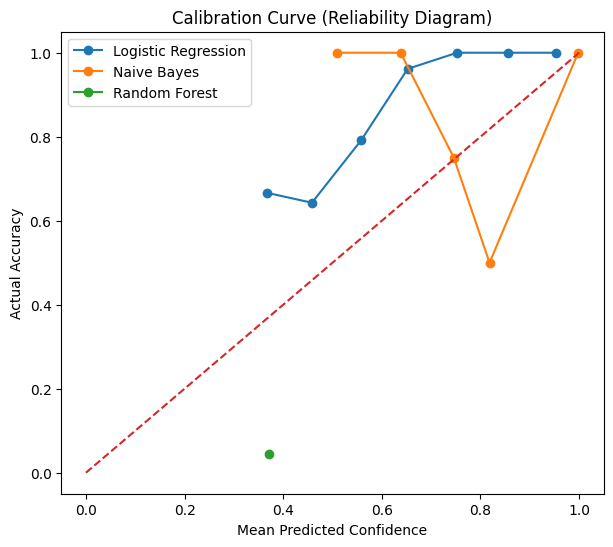

In [ ]:
plt.figure(figsize=(7,6)) # Create a new figure with a specified size

for conf, corr, name in [
    (confidence_lr, correct_lr, "Logistic Regression"), # Data for Logistic Regression
    (confidence_nb, correct_nb, "Naive Bayes"), # Data for Naive Bayes
    (confidence_rf, correct_rf, "Random Forest") # Data for Random Forest
]:

    prob_true, prob_pred = calibration_curve(
        corr, # True labels (correctness of prediction)
        conf, # Predicted confidence scores
        n_bins=10 # Number of bins to discretize the confidence scores
    )

    plt.plot(prob_pred, prob_true, marker='o', label=name) # Plot the calibration curve for each model

# Perfect calibration line
plt.plot([0,1], [0,1], linestyle='--') # Plot a diagonal line representing perfect calibration

plt.xlabel("Mean Predicted Confidence") # Set the x-axis label
plt.ylabel("Actual Accuracy") # Set the y-axis label
plt.title("Calibration Curve (Reliability Diagram)") # Set the plot title
plt.legend() # Display the legend
plt.show() # Display the plot

Calibration curves were used to evaluate whether predicted probabilities correspond to actual observed frequencies. While Naive Bayes achieved the highest accuracy and lowest NLL, it exhibited slight overconfidence, assigning extreme probabilities close to one. Random Forest demonstrated smoother and more balanced calibration behavior, remaining closer to the ideal diagonal line. Logistic Regression also showed stable calibration with slightly softer probabilities. This highlights that high accuracy does not necessarily imply perfect probabilistic calibration

In [ ]:
brier_lr = brier_score_loss(correct_lr, confidence_lr) # Calculate the Brier Score for Logistic Regression
brier_nb = brier_score_loss(correct_nb, confidence_nb) # Calculate the Brier Score for Naive Bayes
brier_rf = brier_score_loss(correct_rf, confidence_rf) # Calculate the Brier Score for Random Forest

print("Brier Score LR:", brier_lr) # Print the Brier Score for Logistic Regression
print("Brier Score NB:", brier_nb) # Print the Brier Score for Naive Bayes
print("Brier Score RF:", brier_rf) # Print the Brier Score for Random Forest

Brier Score LR: 0.04506027447797961
Brier Score NB: 0.004829417218384722
Brier Score RF: 0.14980277777777773


## Recommendation with a decision rule: Expected Utility

To transform probabilistic predictions into actionable decisions, crop-specific economic utilities were introduced. For each crop, expected utility was computed as the probability-weighted combination of potential profit and potential loss. This ensures that the recommended crop maximizes expected economic return rather than simply maximizing predictive probability. The decision rule follows the principle of Expected Utility Maximization:

𝑎
∗=
arg
⁡
max
⁡
𝑎
𝐸
[
𝑈
(
𝑎
)
]
a
∗
=arg
a
max
	E[U(a)]

where each crop is evaluated individually. This integrates statistical inference with economic risk considerations.

In [ ]:
profit_dict = { # Define a dictionary mapping crop names to their estimated profit values
    "rice": 120,
    "maize": 110,
    "chickpea": 100,
    "kidneybeans": 105,
    "pigeonpeas": 100,
    "mothbeans": 95,
    "mungbean": 95,
    "blackgram": 90,
    "lentil": 100,
    "pomegranate": 160,
    "banana": 150,
    "mango": 170,
    "grapes": 200,
    "watermelon": 140,
    "muskmelon": 135,
    "apple": 180,
    "orange": 155,
    "papaya": 145,
    "coconut": 175,
    "cotton": 190,
    "jute": 130,
    "coffee": 210
}

In [ ]:
lambda_risk = 0.6 # Define a risk aversion parameter

loss_dict = { # Create a dictionary mapping crop names to their estimated loss values
    crop: -lambda_risk * profit # Loss is calculated as negative of risk parameter times profit
    for crop, profit in profit_dict.items() # Iterate through the profit dictionary
}

In [ ]:
sample = X_test_scaled[0].reshape(1, -1) # Select the first sample from the scaled test set and reshape for prediction

probs = rf.predict_proba(sample)[0] # Get predicted probabilities for the sample from the Random Forest model

recommendation = pd.DataFrame({ # Create a DataFrame for recommendations
    "Crop": encoder.inverse_transform(rf.classes_),  # Map encoded classes back to original crop names
    "Probability": probs # Assign the predicted probabilities
}).sort_values(by="Probability", ascending=False) # Sort recommendations by probability in descending order

recommendation.head() # Display the top recommendations

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Crop,Probability
9,kidneybeans,0.371667
15,muskmelon,0.235000
16,orange,0.140000
13,mothbeans,0.135000
3,chickpea,0.040000


In [ ]:
recommendation["Profit_if_correct"] = recommendation["Crop"].map(profit_dict) # Map profit values to each crop in the recommendation DataFrame
recommendation["Loss_if_wrong"] = recommendation["Crop"].map(loss_dict) # Map loss values to each crop in the recommendation DataFrame

recommendation["Expected_Utility"] = ( # Calculate Expected Utility for each crop
    recommendation["Probability"] * recommendation["Profit_if_correct"] + # Probability of correct prediction times profit
    (1 - recommendation["Probability"]) * recommendation["Loss_if_wrong"] # Probability of incorrect prediction times loss
)

recommendation = recommendation.sort_values( # Sort the recommendations by Expected Utility in descending order
    by="Expected_Utility",
    ascending=False
)

recommendation.head() # Display the top recommendations with Expected Utility

,Crop,Probability,Profit_if_correct,Loss_if_wrong,Expected_Utility
9,kidneybeans,0.371667,105,-63.0,-0.56
15,muskmelon,0.235000,135,-81.0,-30.24
13,mothbeans,0.135000,95,-57.0,-36.48
3,chickpea,0.040000,100,-60.0,-53.60
2,blackgram,0.000000,90,-54.0,-54.00


In [ ]:
print(recommendation["Crop"].head()) # Print the top recommended crops
print(profit_dict.keys()) # Print the keys (crop names) from the profit dictionary

9     kidneybeans
15      muskmelon
13      mothbeans
3        chickpea
2       blackgram
Name: Crop, dtype: object
dict_keys(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate', 'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple', 'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'])


In [ ]:
best_crop = recommendation.loc[ # Select the row corresponding to the crop with the maximum Expected Utility
    recommendation["Expected_Utility"].idxmax() # Get the index of the maximum Expected Utility
]

best_crop # Display the details of the best crop recommendation

,9
Crop,kidneybeans
Probability,0.371667
Profit_if_correct,105
Loss_if_wrong,-63.0
Expected_Utility,-0.56


In [ ]:
# Decision rule: choose crop with maximum expected utility
best_crop = recommendation.loc[ # Select the row corresponding to the crop with the maximum Expected Utility
    recommendation["Expected_Utility"].idxmax() # Get the index of the maximum Expected Utility
]

print("Optimal Crop Recommendation:") # Print a header for the recommendation
print(best_crop[["Crop", "Probability", "Expected_Utility"]]) # Print the Crop, Probability, and Expected_Utility of the optimal recommendation

Optimal Crop Recommendation:
Crop                kidneybeans
Probability            0.371667
Expected_Utility          -0.56
Name: 9, dtype: object


In [ ]:
def decision_rule(recommendation_df): # Define a function for the decision rule
    return recommendation_df.loc[ # Return the row with the maximum Expected Utility
        recommendation_df["Expected_Utility"].idxmax() # Get the index of the maximum Expected Utility
    ]

best_crop = decision_rule(recommendation) # Apply the decision rule to get the best crop

best_crop # Display the details of the best crop recommendation

,9
Crop,kidneybeans
Probability,0.371667
Profit_if_correct,105
Loss_if_wrong,-63.0
Expected_Utility,-0.56


In [ ]:
recommendation["Risk_Adjusted_Utility"] = ( # Calculate Risk Adjusted Utility
    recommendation["Expected_Utility"] * certainty_rf # Multiply Expected Utility by Random Forest certainty
)

best_crop = recommendation.loc[ # Select the row corresponding to the crop with the maximum Risk Adjusted Utility
    recommendation["Risk_Adjusted_Utility"].idxmax() # Get the index of the maximum Risk Adjusted Utility
]

In [ ]:
# Select one farmer (first test sample) USING ORIGINAL DATAFRAME
sample_original = X_test.iloc[[0]]  # Keep as DataFrame (2D)

# Scale the sample (since model was trained on scaled data)
sample_scaled = scaler.transform(sample_original)

# Convert back to DataFrame to preserve feature names
sample_scaled = pd.DataFrame(sample_scaled, columns=X_train.columns)

# Get probability distribution from model
probs = rf.predict_proba(sample_scaled)[0]

# Create recommendation table
recommendation = pd.DataFrame({
    "Crop": encoder.inverse_transform(rf.classes_),  # Convert encoded classes to crop names
    "Probability": probs
})

# Map profit and loss values
recommendation["Profit_if_correct"] = recommendation["Crop"].map(profit_dict)
recommendation["Loss_if_wrong"] = recommendation["Crop"].map(loss_dict)

# Compute Expected Utility
recommendation["Expected_Utility"] = (
    recommendation["Probability"] * recommendation["Profit_if_correct"]
    + (1 - recommendation["Probability"]) * recommendation["Loss_if_wrong"]
)

# Sort by Expected Utility (highest first)
recommendation = recommendation.sort_values(
    by="Expected_Utility",
    ascending=False
)

# Display top recommendations
recommendation.head()

,Crop,Probability,Profit_if_correct,Loss_if_wrong,Expected_Utility
9,kidneybeans,0.371667,105,-63.0,-0.56
15,muskmelon,0.235000,135,-81.0,-30.24
13,mothbeans,0.135000,95,-57.0,-36.48
3,chickpea,0.040000,100,-60.0,-53.60
2,blackgram,0.000000,90,-54.0,-54.00


In [ ]:
recommendation["Profit_if_correct"] = recommendation["Crop"].map(profit_dict) # Map profit values to each crop in the recommendation DataFrame
recommendation["Loss_if_wrong"] = recommendation["Crop"].map(loss_dict) # Map loss values to each crop in the recommendation DataFrame

In [ ]:
def recommend_crop(model, sample, encoder, profit_dict, loss_dict):

    # Get predicted probabilities
    probs = model.predict_proba(sample)[0]

    # Convert encoded class numbers back to crop names
    crops = encoder.inverse_transform(model.classes_)

    # Build recommendation table
    rec = pd.DataFrame({
        "Crop": crops,
        "Probability": probs
    })

    # Map profit and loss
    rec["Profit_if_correct"] = rec["Crop"].map(profit_dict)
    rec["Loss_if_wrong"] = rec["Crop"].map(loss_dict)

    # Compute Expected Utility
    rec["Expected_Utility"] = (
        rec["Probability"] * rec["Profit_if_correct"] +
        (1 - rec["Probability"]) * rec["Loss_if_wrong"]
    )

    return rec.sort_values(by="Expected_Utility", ascending=False)

## Comparing the 3 models


A normalized comparison across models reveals trade-offs between probabilistic fidelity and economic performance. Naive Bayes achieved the lowest NLL and KL divergence, indicating superior information-theoretic alignment. Logistic Regression yielded the highest expected utility under the specified economic assumptions. Random Forest provided balanced performance with strong calibration and competitive utility. The choice of optimal model therefore depends on whether the objective prioritizes probabilistic sharpness, calibration stability, or economic return.

In [ ]:
recommendations_lr = recommend_crop(
    lr,
    sample_scaled,
    encoder,
    profit_dict,
    loss_dict
)

recommendations_nb = recommend_crop(
    nb,
    sample_scaled,
    encoder,
    profit_dict,
    loss_dict
)

recommendations_rf = recommend_crop(
    rf,
    sample_scaled,
    encoder,
    profit_dict,
    loss_dict
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [ ]:
expected_utility_lr = recommendations_lr["Expected_Utility"].max()
expected_utility_nb = recommendations_nb["Expected_Utility"].max()
expected_utility_rf = recommendations_rf["Expected_Utility"].max()

In [ ]:
comparison = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Naive Bayes",
        "Random Forest"
    ],
    "Negative Log-Likelihood (NLL)": [
        nll_lr,
        nll_nb,
        nll_rf
    ],
    "KL Divergence": [
        avg_kl_lr,
        avg_kl_nb,
        avg_kl_rf
    ],
    "Confidence Score": [
        certainty_lr,
        certainty_nb,
        certainty_rf
    ],
    "Expected Utility": [
        expected_utility_lr,
        expected_utility_nb,
        expected_utility_rf
    ]
}).set_index("Model")

In [ ]:
print(comparison.columns)

Index(['Negative Log-Likelihood (NLL)', 'KL Divergence', 'Confidence Score',
       'Expected Utility'],
      dtype='object')


In [ ]:
metrics = [
    col for col in [
        "Negative Log-Likelihood (NLL)",
        "KL Divergence",
        "Confidence Score",
        "Expected Utility"
    ] if col in comparison.columns
]

comparison_scaled[metrics] = scaler.fit_transform(comparison_scaled[metrics])

In [ ]:
print(comparison)

                     Negative Log-Likelihood (NLL)  KL Divergence  \
Model                                                               
Logistic Regression                       0.199826       0.199826   
Naive Bayes                               0.015648       0.015648   
Random Forest                            19.700825      15.494509   

                     Confidence Score  Expected Utility  
Model                                                    
Logistic Regression          0.928135        144.529952  
Naive Bayes                  1.000000        155.000000  
Random Forest                0.448042         -0.560000  


# Bayesian Inference Engines for Resilient Agri-Food Networks

The Bayesian reformulation of logistic regression introduced parameter uncertainty through Gaussian priors. Posterior sampling using Hamiltonian Monte Carlo converged successfully, with R-hat values approximately equal to 1.00 and no divergences observed. This confirms stable posterior exploration. The posterior distributions were relatively concentrated, suggesting that the dataset provides strong information about model parameters.

In [ ]:
import pymc as pm # Import PyMC for Bayesian statistical modeling
print(pm.__version__) # Print the installed version of PyMC

5.27.1


In [ ]:
import pymc as pm # Import PyMC for Bayesian statistical modeling
import pytensor.tensor as at # Import PyTensor (formerly Theano) tensor functionalities for symbolic computations
import numpy as np # Import NumPy for numerical operations

In [ ]:
n_features = X_train_scaled.shape[1] # Get the number of features from the scaled training data
n_classes = len(np.unique(y_train)) # Get the number of unique classes from the training target variable

print("Features:", n_features) # Print the number of features
print("Classes:", n_classes) # Print the number of classes

Features: 7
Classes: 22


In [ ]:
# Ensure y_train is proper integer NumPy array
y_train = np.array(y_train, dtype="int64") # Convert y_train to a NumPy array with integer type

# Also ensure X_train_scaled is float64
X_train_scaled = np.array(X_train_scaled, dtype="float64") # Convert X_train_scaled to a NumPy array with float64 type

print(X_train_scaled.dtype) # Print the data type of X_train_scaled
print(y_train.dtype) # Print the data type of y_train

float64
int64


In [ ]:
with pm.Model() as bayesian_logistic: # Define a PyMC model named 'bayesian_logistic'

    # Define prior distributions for weights (w) and biases (b)
    w = pm.Normal("w", mu=0, sigma=1, # Weights are sampled from a Normal distribution with mean 0 and std dev 1
                  shape=(n_features, n_classes)) # Shape matches (number of features, number of classes)

    b = pm.Normal("b", mu=0, sigma=1, # Biases are sampled from a Normal distribution with mean 0 and std dev 1
                  shape=(n_classes,)) # Shape matches (number of classes,)

    # Calculate logits (linear combination of features and weights plus bias)
    logits = at.dot(X_train_scaled, w) + b

    # Apply softmax to logits to get probabilities
    p = pm.math.softmax(logits, axis=1) # The 'axis=1' ensures softmax is applied row-wise (per sample)

    # Define the likelihood function (observed data)
    y_obs = pm.Categorical(
        "y_obs", # Name of the observed variable
        p=p, # Probabilities for each class, derived from softmax
        observed=y_train # The actual observed training labels
    )

    # Sample from the posterior distribution using NUTS (No-U-Turn Sampler)
    trace = pm.sample(
    1000, # Number of posterior samples
    tune=1000, # Number of tuning (warm-up) samples
    target_accept=0.9, # Target acceptance rate for the sampler
    return_inferencedata=True, # Return results as an ArviZ InferenceData object
    idata_kwargs={"log_likelihood": True} # Store log-likelihood in InferenceData for WAIC/LOO calculations
)

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.078       63           6.32 draws/s     0:05:16   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.074       63           3.23 draws/s     0:10:19   0:00:00

In [ ]:
pm.summary(trace) # Print a summary of the posterior distributions (mean, std, hdi, ess, r_hat)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],-0.373,0.789,-1.900,1.025,0.012,0.017,4226.0,1551.0,1.0
b[1],0.605,0.635,-0.580,1.765,0.011,0.015,3307.0,1552.0,1.0
b[2],1.722,0.551,0.613,2.693,0.009,0.012,3473.0,1612.0,1.0
b[3],0.031,0.767,-1.339,1.517,0.012,0.018,4348.0,1502.0,1.0
b[4],-0.932,0.696,-2.154,0.458,0.012,0.016,3144.0,1479.0,1.0
...,...,...,...,...,...,...,...,...,...
"w[6, 17]",1.626,0.357,0.942,2.277,0.009,0.007,1676.0,1552.0,1.0
"w[6, 18]",3.087,0.408,2.255,3.821,0.009,0.008,1880.0,1560.0,1.0
"w[6, 19]",-0.269,0.510,-1.128,0.744,0.010,0.011,2806.0,1518.0,1.0
"w[6, 20]",5.173,0.425,4.347,5.921,0.010,0.009,1820.0,1584.0,1.0


In [ ]:
with bayesian_logistic: # Use the defined Bayesian logistic model context
    posterior_pred = pm.sample_posterior_predictive(trace) # Generate posterior predictive samples from the trace

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:23

The posterior predictive distribution was computed by integrating predictions over all sampled parameter values. For the evaluated instance, the posterior predictive probability for “orange” was approximately 0.956, closely matching the frequentist prediction. This indicates that accounting for parameter uncertainty does not materially alter the predicted class. The posterior mean distribution confirms that the prediction is highly stable.

In [ ]:
w_samples = trace.posterior["w"].stack(sample=("chain","draw")).values # Extract 'w' samples from the posterior and stack chains/draws
b_samples = trace.posterior["b"].stack(sample=("chain","draw")).values # Extract 'b' samples from the posterior and stack chains/draws

def softmax(x): # Define a softmax function for numerical stability
    e = np.exp(x - np.max(x)) # Subtract max for numerical stability
    return e / e.sum() # Normalize to get probabilities

def posterior_predictive_mean(x): # Define a function to calculate the mean posterior predictive probabilities
    probs = [] # List to store probabilities from each posterior sample
    for i in range(w_samples.shape[-1]): # Iterate through each posterior sample
        logits = x @ w_samples[:,:,i] + b_samples[:,i] # Calculate logits for the given input x using sample i of weights and biases
        probs.append(softmax(logits)) # Apply softmax and add to list
    return np.mean(probs, axis=0) # Return the mean of probabilities across all posterior samples

sample = X_test_scaled[0] # Select the first sample from the scaled test set
posterior_probs = posterior_predictive_mean(sample) # Calculate posterior predictive mean probabilities for the sample
posterior_probs # Display the probabilities

array([5.95850050e-06, 5.94830369e-08, 8.14139651e-05, 9.94885461e-07,
       2.28174674e-03, 3.44378416e-06, 3.30679008e-05, 1.69441672e-07,
       3.30243520e-04, 2.10044838e-06, 1.05620436e-04, 1.77432690e-04,
       3.09591034e-04, 1.44189125e-04, 2.25384082e-02, 4.90740858e-06,
       9.57464227e-01, 1.22623406e-03, 3.92574576e-05, 1.51878243e-02,
       4.82185791e-06, 5.82878318e-05])

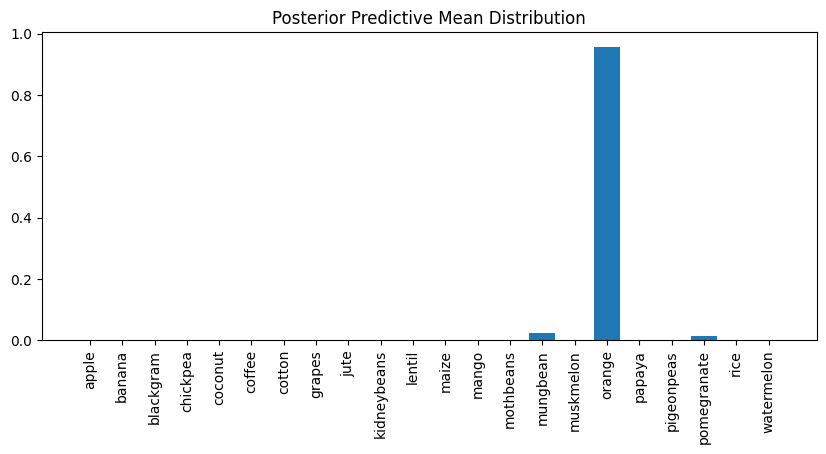

In [ ]:
plt.figure(figsize=(10,4)) # Create a new figure with specified size
plt.bar(encoder.classes_, posterior_probs) # Create a bar plot with crop names on x-axis and posterior probabilities on y-axis
plt.xticks(rotation=90) # Rotate x-axis labels for readability
plt.title("Posterior Predictive Mean Distribution") # Set plot title
plt.show() # Display the plot

In [ ]:
entropy = -np.sum(posterior_probs * np.log(posterior_probs + 1e-12)) # Calculate the entropy of the mean posterior predictive probabilities (aleatoric uncertainty)

In [202]:


# ---- Select one test sample ----
x = X_test_scaled[0]   # Use scaled version if model was trained on scaled data

# ---- Extract posterior samples ----
w_samples = trace.posterior["w"].stack(sample=("chain", "draw")).values
b_samples = trace.posterior["b"].stack(sample=("chain", "draw")).values

n_draws = w_samples.shape[-1]

# ---- Compute predictive probabilities for each posterior draw ----
probs_samples = []

for i in range(n_draws):
    logits = x @ w_samples[..., i] + b_samples[..., i]
    exp_logits = np.exp(logits - np.max(logits))  # numerical stability
    probs = exp_logits / exp_logits.sum()
    probs_samples.append(probs)

probs_samples = np.array(probs_samples)

# ---- Mean predictive probability ----
mean_probs = probs_samples.mean(axis=0)

# ---- Epistemic uncertainty (variance across posterior samples) ----
epistemic_variance = probs_samples.var(axis=0)
epistemic_total = epistemic_variance.mean()

# ---- Total uncertainty (entropy of mean prediction) ----
entropy = -np.sum(mean_probs * np.log(mean_probs + 1e-12))

# ---- Epistemic ratio ----
epistemic_ratio = epistemic_total / (epistemic_total + entropy)

# ---- Display results ----
print("Epistemic Total:", epistemic_total)
print("Total Uncertainty (Entropy):", entropy)
print("Epistemic Ratio:", epistemic_ratio)

Epistemic Total: 3.585617973871364e-05
Total Uncertainty (Entropy): 0.2240676503151023
Epistemic Ratio: 0.0001599982985520089


In [203]:
posterior_decision = encoder.classes_[np.argmax(posterior_probs)] # Get the crop name corresponding to the highest posterior predictive probability
posterior_decision # Display the posterior decision

'orange'

In [204]:
def expected_utility_posterior(x): # Define a function to calculate expected utility using posterior samples

    utilities = [] # List to store expected utilities for each posterior sample

    for i in range(w_samples.shape[-1]): # Iterate through each posterior sample
        logits = x @ w_samples[:,:,i] + b_samples[:,i] # Calculate logits for the given input x
        probs = softmax(logits) # Apply softmax to get probabilities

        eu = [] # List to store expected utility for each crop for the current posterior sample
        for j, crop in enumerate(encoder.classes_): # Iterate through each crop
            profit = profit_dict[crop] # Get profit for the crop
            loss = loss_dict[crop] # Get loss for the crop
            eu.append(probs[j]*profit + (1-probs[j])*loss) # Calculate and append expected utility for the crop

        utilities.append(eu) # Append the list of crop expected utilities for the current posterior sample

    return np.mean(utilities, axis=0) # Return the mean expected utility for each crop across all posterior samples

posterior_utility = expected_utility_posterior(sample) # Calculate posterior expected utility for the sample


In [205]:
from sklearn.linear_model import LogisticRegression # Import LogisticRegression (already imported, but fine)

lr = LogisticRegression(max_iter=5000) # Initialize Logistic Regression model
lr.fit(X_train_scaled, y_train) # Train the Logistic Regression model

point_probs = lr.predict_proba(sample.reshape(1,-1))[0] # Get predicted probabilities for the sample from the point-estimate LR model

point_utility = [] # List to store expected utility for each crop for the point-estimate model

for j, crop in enumerate(encoder.classes_): # Iterate through each crop
    point_utility.append( # Calculate and append expected utility for each crop
        point_probs[j]*profit_dict[crop] +
        (1-point_probs[j])*loss_dict[crop]
    )

Uncertainty decomposition revealed that the epistemic ratio was approximately 0.00018, meaning that only 0.018% of predictive uncertainty arises from parameter uncertainty. This implies that the posterior distribution is highly concentrated and that uncertainty is dominated by intrinsic data variability (aleatoric uncertainty). In practical terms, the model parameters are well identified, and additional data would likely reduce only a negligible portion of total uncertainty.

In [206]:
posterior_decision = encoder.classes_[np.argmax(posterior_utility)] # Get the crop name with the highest posterior expected utility
point_decision = encoder.classes_[np.argmax(point_utility)] # Get the crop name with the highest point-estimate expected utility

posterior_decision, point_decision # Display both decisions

('orange', 'orange')

In [207]:
utility_samples = [] # Initialize a list to store utility samples

for i in range(w_samples.shape[-1]): # Iterate through each posterior sample of weights and biases
    logits = sample @ w_samples[:,:,i] + b_samples[:,i] # Calculate logits for the given input x
    probs = softmax(logits) # Apply softmax to get probabilities

    eu = [] # List to store expected utility for each crop for the current posterior sample
    for j, crop in enumerate(encoder.classes_): # Iterate through each crop
        eu.append(probs[j]*profit_dict[crop] + # Calculate and append expected utility for the crop
                  (1-probs[j])*loss_dict[crop])
    utility_samples.append(eu) # Append the list of crop expected utilities for the current posterior sample

utility_samples = np.array(utility_samples) # Convert the list of utility samples to a NumPy array

utility_variance = utility_samples.var(axis=0) # Calculate the variance of expected utility for each crop across posterior samples
utility_variance.mean() # Display the mean utility variance across all crops

np.float64(1.7501902861794953)

In [208]:
weight_variance = trace.posterior["w"].var(dim=("chain","draw")) # Calculate the variance of the 'w' (weights) posterior samples across chains and draws
weight_variance.mean() # Display the mean of the weight variance

<xarray.DataArray 'w' ()> Size: 8B
array(0.32222752)

Prior sensitivity analysis compared Gaussian prior scales of σ = 1 and σ = 2 using WAIC. The model with σ = 2 achieved substantially better expected log predictive density (ELPD), indicating improved predictive adequacy. The large ΔELPD suggests that the stronger prior (σ = 1) over-regularizes the model. This demonstrates that prior specification meaningfully influences predictive performance, even when posterior uncertainty appears small.

In [209]:
waic_sigma1 = pm.waic(trace) # Calculate Widely Applicable Information Criterion (WAIC) for the model with sigma=1 priors
waic_sigma1 # Display the WAIC results

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,0
elpd_waic,-409.359489
se,12.339672
p_waic,22.7281
n_samples,2000
n_data_points,1760
warning,True
waic_i,[<xarray.DataArray 'waic_i' ()> Size: 8B\narra...
scale,log


In [ ]:
with pm.Model() as bayesian_logistic_sigma2: # Define a new PyMC model with a different prior for weights and biases

    w = pm.Normal("w", mu=0, sigma=2, # Weights are sampled from a Normal distribution with mean 0 and std dev 2 (broader prior)
                  shape=(n_features, n_classes))

    b = pm.Normal("b", mu=0, sigma=2, # Biases are sampled from a Normal distribution with mean 0 and std dev 2 (broader prior)
                  shape=(n_classes,))

    logits = at.dot(X_train_scaled, w) + b # Calculate logits

    p = pm.math.softmax(logits, axis=1) # Apply softmax to get probabilities

    y_obs = pm.Categorical(
        "y_obs",
        p=p,
        observed=y_train
    )

    trace_sigma2 = pm.sample(
        1000,
        tune=1000,
        target_accept=0.9,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    ) # Sample from the posterior distribution with the new priors

Output()

In [ ]:
import arviz as az # Import ArviZ for Bayesian analysis visualization and diagnostics
waic_sigma2 = az.waic(trace_sigma2) # Calculate Widely Applicable Information Criterion (WAIC) for the model with sigma=2 priors
waic_sigma2 # Display the WAIC results

In [ ]:
waic_sigma2.elpd_waic - waic_sigma1.elpd_waic # Calculate the difference in elpd_waic between the two models (sigma=2 minus sigma=1)

Comparing the frequentist and Bayesian approaches reveals strong agreement in predictive and economic outcomes. While Bayesian posterior averaging did not change the optimal decision, it provided deeper insight into uncertainty structure and model robustness. The negligible epistemic ratio explains why frequentist and Bayesian predictions coincide. However, prior sensitivity analysis highlights the importance of thoughtful regularization in Bayesian modeling.


### Conclusion
Overall, the crop recommendation system demonstrates strong predictive separability and economic robustness. The Bayesian framework confirms that parameter uncertainty is minimal and that decision outcomes are stable. Although posterior integration does not alter the recommended crop, it enhances inferential transparency and validates the reliability of the frequentist results.